In [1]:
using ProgressMeter
using JLD
using Random
include("../alpcahus.jl")
include("../helperFunctions.jl")
include("../cluster.jl")

hungarianAlgorithm (generic function with 1 method)

In [2]:
D = 50 # ambient space dimension
d = 3 # subspace dimension
goodPoints = 6 # good points per subspace
ν1 = 0.1 # noise variance good points
K = 2 # subspace count
varianceRatio = range( 1,300,10) # variance ratio for heatmaps
#pointRatio = range(1,50,5) # point ratio between good bad data for heatmaps
pointRatio = 38
trials = 100; # smoother results
qValue = 24;

In [3]:
seedVector1 = rand(Xoshiro(1234), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector2 = rand(Xoshiro(4321), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector3 = rand(Xoshiro(2143), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector4 = rand(Xoshiro(3412), 1:100000, trials*length(varianceRatio)*length(pointRatio));

In [4]:
# ν2 = varianceRatio[2]*ν1
# badPoints = round(Int, pointRatio*goodPoints)
# # subspace generation
# U1 = generateSubspace(D, d; seed=seedVector1[1]) 
# U2 = generateSubspace(D, d; seed=seedVector2[2])
# # data generation
# X1 = generateData(U1, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector3[3])
# X2 = generateData(U2, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector4[4])
# # complete data matrix
# X = hcat(X1,X2);
# # cluster assignments
# C = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
# # TIPS
# estimatedCluster = TIPS(X, K; τ=10)
# clusterError(estimatedCluster, C)

In [5]:
kss_ri_matrix = zeros(length(varianceRatio),trials)
kss_tips_matrix = zeros(length(varianceRatio),trials)
alpcah_ri_matrix = zeros(length(varianceRatio),trials)
alpcah_tips_matrix = zeros(length(varianceRatio),trials)
noisy_oracle_matrix = zeros(length(varianceRatio),trials)

count = 1
@showprogress 1 "Running..." for i = 1:length(varianceRatio) # varianceRatio
        for k = 1:trials
            # other parameters
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio*goodPoints)
            # subspace generation
            U1 = generateSubspace(D, d; seed=seedVector1[count]) 
            U2 = generateSubspace(D, d; seed=seedVector2[count])
            # data generation
            X1 = generateData(U1, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector3[count])
            X2 = generateData(U2, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector4[count])
            # complete data matrix
            X = hcat(X1,X2);
            # cluster assignments
            C = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
        
            # kss RI
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=1, q=qValue, T=100, subspaceMethod=:pca, finalStep=false)
            kss_ri_matrix[i,k] = clusterError(estimatedCluster, C)

            # kss TIPS
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=1, q=qValue, T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true, τ=5)
            kss_tips_matrix[i,k] = clusterError(estimatedCluster, C)
        
            # alpcahus RI
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=1, q=qValue, T=100, alpcahIter=100, subspaceMethod=:alpcah, finalStep=true, varfloor=1e-9) 
            alpcah_ri_matrix[i,k] = clusterError(estimatedCluster, C)

            # alpcahus TIPS
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=1, q=qValue, T=100, alpcahIter=100, subspaceMethod=:alpcah, finalStep=true, varfloor=1e-9, spectralStart=true, τ=5) 
            alpcah_tips_matrix[i,k] = clusterError(estimatedCluster, C)
        
            # noisy oracle trial       
            noisyU1 = svd(X1[:,1:goodPoints]).U[:,1:d]
            noisyU2 = svd(X2[:,1:goodPoints]).U[:,1:d]
            estimatedCluster = 1 .+ Vector{Int8}(norm.(eachcol(noisyU1'*X)) .> norm.(eachcol(noisyU2'*X)));
            noisy_oracle_matrix[i,k] = clusterError(estimatedCluster, C)
        
            # increase count
            count = count + 1
        end
end

Running... 100%|█████████████████████████████████████████| Time: 2:35:57


In [25]:
save("trialData.jld", "kss-ri", kss_ri_matrix, "kss-tips", kss_tips_matrix, "alpcah-ri", alpcah_ri_matrix, "alpcah-tips", alpcah_tips_matrix,"oracle",noisy_oracle_matrix);

In [4]:
kss_ri_matrix = load("trialData.jld", "kss-ri")
kss_tips_matrix = load("trialData.jld", "kss-tips")
alpcah_ri_matrix = load("trialData.jld", "alpcah-ri")
alpcah_tips_matrix = load("trialData.jld", "alpcah-tips")
noisy_oracle_matrix = load("trialData.jld", "oracle");

In [5]:
noisy_oracle_vector = mean(noisy_oracle_matrix, dims=2)
kss_ri_vector = mean(kss_ri_matrix, dims=2)
kss_tips_vector = mean(kss_tips_matrix, dims=2)
alpcah_ri_vector = mean(alpcah_ri_matrix, dims=2)
alpcah_tips_vector = mean(alpcah_tips_matrix, dims=2);

In [6]:
noisy_oracle_std = std(noisy_oracle_matrix, dims=2)
kss_ri_std = std(kss_ri_matrix, dims=2)
kss_tips_std = std(kss_tips_matrix, dims=2)
alpcah_ri_std = std(alpcah_ri_matrix, dims=2)
alpcah_tips_std = std(alpcah_tips_matrix, dims=2);

In [7]:
colors = theme_palette(:default)

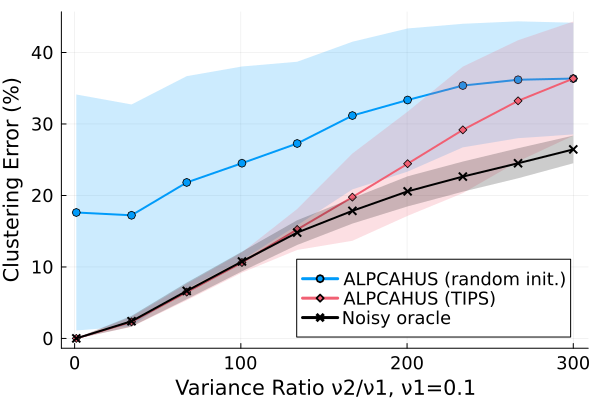

In [15]:
plot(title="", xlabel="Variance Ratio ν2/ν1, ν1=$ν1", ylabel="Clustering Error (%)", legend=:bottomright, legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=14,titlefontsize=18)
#plot!(varianceRatio, kss_ri_vector, label="kss-ri", marker=:o, color=colors[1], linewidth=2)
#plot!(varianceRatio, kss_tips_vector, label="kss-tips", marker=:diamond, color=colors[3], linewidth=2)
plot!(varianceRatio, alpcah_ri_vector, ribbon=alpcah_ri_std, label="ALPCAHUS (random init.)", marker=:o, color=colors[1], linewidth=2, fillalpha=0.2)
plot!(varianceRatio, alpcah_tips_vector, ribbon=alpcah_tips_std, label="ALPCAHUS (TIPS)", marker=:diamond, color=colors[end-2], linewidth=2, fillalpha=0.2)
plot!(varianceRatio, noisy_oracle_vector, ribbon=noisy_oracle_std, label="Noisy oracle", marker=:x, color=:black, linewidth=2, fillalpha=0.2)
#savefig("spectral_init_mean.pdf")

In [10]:
noisy_oracle_vector2 = var(noisy_oracle_matrix, dims=2)
kss_ri_vector2 = var(kss_ri_matrix, dims=2)
kss_tips_vector2 = var(kss_tips_matrix, dims=2)
alpcah_ri_vector2 = var(alpcah_ri_matrix, dims=2)
alpcah_tips_vector2 = var(alpcah_tips_matrix, dims=2);

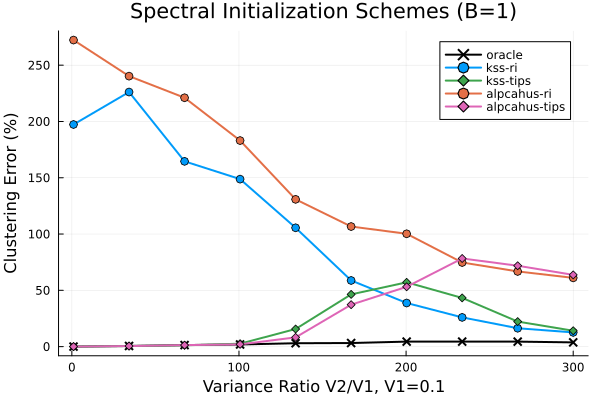

In [12]:
plot(title="Spectral Initialization Schemes (B=1)", xlabel="Variance Ratio V2/V1, V1=$ν1", ylabel="Clustering Error (%)", legend=:topright, fontsize = 15)
plot!(varianceRatio, noisy_oracle_vector2, label="oracle", marker=:x, color=:black, linewidth=2)
plot!(varianceRatio, kss_ri_vector2, label="kss-ri", marker=:o, color=colors[1], linewidth=2)
plot!(varianceRatio, kss_tips_vector2, label="kss-tips", marker=:diamond, color=colors[3], linewidth=2)
plot!(varianceRatio, alpcah_ri_vector2, label="alpcahus-ri", marker=:o, color=colors[2], linewidth=2)
plot!(varianceRatio, alpcah_tips_vector2, label="alpcahus-tips", marker=:diamond, color=colors[end-1], linewidth=2)
#savefig("spectral_init_var.pdf")

In [20]:
noisy_oracle_vector3 = median(noisy_oracle_matrix, dims=2)
kss_ri_vector3 = median(kss_ri_matrix, dims=2)
kss_tips_vector3 = median(kss_tips_matrix, dims=2)
alpcah_ri_vector3 = median(alpcah_ri_matrix, dims=2)
alpcah_tips_vector3 = median(alpcah_tips_matrix, dims=2);

In [21]:
plot(title="Spectral Initialization Schemes (B=1)", xlabel="Variance Ratio V2/V1, V1=$ν1", ylabel="Clustering Error (%)", legend=:bottomright, fontsize = 15)
plot!(varianceRatio, noisy_oracle_vector3, label="oracle", marker=:x, color=:black, linewidth=2)
plot!(varianceRatio, kss_ri_vector3, label="kss-ri", marker=:o, color=colors[1], linewidth=2)
plot!(varianceRatio, kss_tips_vector3, label="kss-tips", marker=:diamond, color=colors[3], linewidth=2)
plot!(varianceRatio, alpcah_ri_vector3, label="alpcahus-ri", marker=:o, color=colors[2], linewidth=2)
plot!(varianceRatio, alpcah_tips_vector3, label="alpcahus-tips", marker=:diamond, color=colors[end-1], linewidth=2)
savefig("spectral_init_median.pdf")

"/home/javier/Desktop/alpcahus/spectral_initialization/spectral_init_median.pdf"